In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
from google.colab import drive

drive.mount('/content/gdrive')

path = '/content/gdrive/MyDrive/Colab_Notebooks/FYP/'

In [ ]:
# read data
full_training_data = pd.read_csv(path+'data/full_training_data_cleaned.csv',index_col=False)

In [ ]:
# Min-Max Scaling
min_max_column = ['Open', 'High', 'Low', 'Volume',
                  'wsentiments', 'HSI_overnight_ret',
                  'HSI_intraday_overnight_ret_diff', 'CSI300_overnight_ret',
                  'SSE50_overnight_ret', 'HSI_stoch_k', 'HSI_rsi', 'HSI_daily_ret',
                  'HSI_intraday_ret', 'HSI_ret_range']

mms_X = MinMaxScaler()
full_training_data[min_max_column] = mms_X.fit_transform(full_training_data[min_max_column])

mms_y = MinMaxScaler()
full_training_data['Adj Close'] = mms_y.fit_transform(full_training_data[['Adj Close']])

In [ ]:
# Feature selection
regression_feature_column = ['Open', 'High', 'Low', 'Volume', 'HSI_overnight_ret',
                             'HSI_intraday_overnight_ret_diff',
                             'CSI300_overnight_ret', 'SSE50_overnight_ret',
                             'HSI_stoch_k', 'HSI_rsi', 'HSI_daily_ret',
                             'HSI_disc_macd_1', 'HSI_intraday_ret',
                             'HSI_ret_range']

regression_nlp_column = ['Open', 'High', 'Low', 'Volume', 'HSI_overnight_ret',
                         'HSI_intraday_overnight_ret_diff',
                         'CSI300_overnight_ret', 'SSE50_overnight_ret',
                         'HSI_stoch_k', 'HSI_rsi', 'HSI_daily_ret',
                         'HSI_disc_macd_1', 'HSI_intraday_ret', 'HSI_ret_range',
                         'wsentiments']

regression_feature_df = full_training_data[regression_feature_column]
regression_nlp_df = full_training_data[regression_nlp_column]

In [ ]:
# Prepare the dataset
def train(X, y):

  # Split the data into training (70%), testing (15%), and validation (15%) sets
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1765, random_state=42)

  # Create the XGBoost model with a reduced number of estimators
  model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=200, random_state=42)

  # Set up the hyperparameter distributions for tuning
  param_dist = {
      'max_depth': sp_randint(1, 6),
      'min_child_weight': sp_randint(1, 10),
      'gamma': sp_uniform(0, 1),
      'subsample': sp_uniform(0.4, 0.6),
      'colsample_bytree': sp_uniform(0.4, 0.6),
      'reg_alpha': sp_uniform(0, 3),
      'reg_lambda': sp_uniform(0, 3),
      'learning_rate': sp_uniform(0.005, 0.05)
  }

  # Perform randomized search with a given number of iterations
  n_iter_search = 75
  random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=n_iter_search, cv=5,
                                    scoring='neg_mean_squared_error', verbose=1, n_jobs=-1, random_state=42)

  random_search.fit(X_train, y_train)

  # Print the best combination of hyperparameters
  print("Best hyperparameters found using randomized search:")
  print(random_search.best_params_)

  # Train the model with the best hyperparameters
  best_model = random_search.best_estimator_
  best_model.fit(X_train, y_train, early_stopping_rounds=10, eval_set=[(X_val, y_val)], verbose=False)

  # Make predictions
  y_pred_train = best_model.predict(X_train)
  y_pred_val = best_model.predict(X_val)
  y_pred_test = best_model.predict(X_test)

  # Return original value
  y_train = mms_y.inverse_transform(np.array(y_train).reshape(1, -1))[0]
  print(y_train)
  y_val = mms_y.inverse_transform(np.array(y_val).reshape(1, -1))[0]
  y_test = mms_y.inverse_transform(np.array(y_test).reshape(1, -1))[0]
  y_pred_train = mms_y.inverse_transform(np.array(y_pred_train).reshape(1, -1))[0]
  y_pred_val = mms_y.inverse_transform(np.array(y_pred_val).reshape(1, -1))[0]
  y_pred_test = mms_y.inverse_transform(np.array(y_pred_test).reshape(1, -1))[0]

  # Calculate root mean squared error
  rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
  rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))
  rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

  # Calculate MAPE
  mape_train = mean_absolute_percentage_error(y_train, y_pred_train)
  mape_val = mean_absolute_percentage_error(y_val, y_pred_val)
  mape_test = mean_absolute_percentage_error(y_test, y_pred_test)

  # Calculate R2 score
  r2_train = r2_score(y_train, y_pred_train)
  r2_val = r2_score(y_val, y_pred_val)
  r2_test = r2_score(y_test, y_pred_test)

  print(f"RMSE on training set: {rmse_train:.2f}")
  print(f"RMSE on validation set: {rmse_val:.2f}")
  print(f"RMSE on testing set: {rmse_test:.2f}")

  print(f"MAPE on training set: {mape_train:.2f}")
  print(f"MAPE on validation set: {mape_val:.2f}")
  print(f"MAPE on testing set: {mape_test:.2f}")

  print(f"R2 score on training set: {r2_train:.2f}")
  print(f"R2 score on validation set: {r2_val:.2f}")
  print(f"R2 score on testing set: {r2_test:.2f}")

  return X_train, X_val, X_test, y_train, y_val, y_test, y_pred_train, y_pred_val, y_pred_test

In [ ]:
# Plot the results
def plot_graph(X_train, X_val, X_test, y_pred_train, y_pred_val, y_pred_test, version):

  fig, ax = plt.subplots(figsize=(10, 6))
  ax.plot(full_training_data["Date"], mms_y.inverse_transform(np.array(full_training_data["Adj Close"]).reshape(1, -1))[0], label="Actual Price", color="blue")

  # Sort the training, testing, and validation predictions by date
  train_pred_df = pd.DataFrame({'Date': full_training_data.loc[X_train.index, 'Date'], 'Predicted': y_pred_train})
  val_pred_df = pd.DataFrame({'Date': full_training_data.loc[X_val.index, 'Date'], 'Predicted': y_pred_val})
  test_pred_df = pd.DataFrame({'Date': full_training_data.loc[X_test.index, 'Date'], 'Predicted': y_pred_test})

  # Sort by Date
  train_pred_df = train_pred_df.sort_values(by='Date').reset_index(drop=True)
  val_pred_df = val_pred_df.sort_values(by='Date').reset_index(drop=True)
  test_pred_df = test_pred_df.sort_values(by='Date').reset_index(drop=True)

  result = pd.concat([train_pred_df, val_pred_df])
  result = pd.concat([result, test_pred_df])
  result = result.sort_values(by='Date').reset_index(drop=True)

  # output result
  result.to_csv(path+f'xgboost_stock_prediction_regression_{version}.csv', index=False)

  # Scatter Plot for each set of data
  ax.scatter(train_pred_df["Date"], train_pred_df["Predicted"], label="Predicted Price (Train)", color="green", s=10)
  ax.scatter(val_pred_df["Date"], val_pred_df["Predicted"], label="Predicted Price (Val)", color="orange", s=10)
  ax.scatter(test_pred_df["Date"], test_pred_df["Predicted"], label="Predicted Price (Test)", color="red", s=10)

  ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=10))
  ax.set_ylabel("Hang Seng Index Price")
  ax.set_xlabel("Date")
  plt.xticks(rotation=90)
  ax.legend()
  plt.show()
  return None

**XGBoost Vanilla + Features**

Fitting 5 folds for each of 75 candidates, totalling 375 fits
Best hyperparameters found using randomized search:
{'colsample_bytree': 0.9069251865816728, 'gamma': 0.023271935735825866, 'learning_rate': 0.04572342412944679, 'max_depth': 1, 'min_child_weight': 7, 'reg_alpha': 0.35449448286496876, 'reg_lambda': 2.090211496092452, 'subsample': 0.7773657080679304}
[24193.34960938 20890.25976562 24480.15039062 24907.33984375
 19531.66015625 25867.00976562 28189.75       22952.24023438
 19968.38085938 25033.2109375  20765.86914062 17250.88085938
 29718.24023438 23311.0703125  29297.52929688 26156.859375
 21872.00976562 28309.75976562 23749.11914062 25878.99023438
 26192.3203125  23635.94921875 29642.27929688 21725.77929688
 26129.1796875  26389.51953125 26410.58984375 27959.59960938
 25716.         22229.51953125 20171.26953125 29476.18945312
 27655.81054688 24754.41992188 19597.31054688 28773.23046875
 22761.7109375  19689.2109375  28795.91015625 21067.99023438
 24099.140625   28496.859375 

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


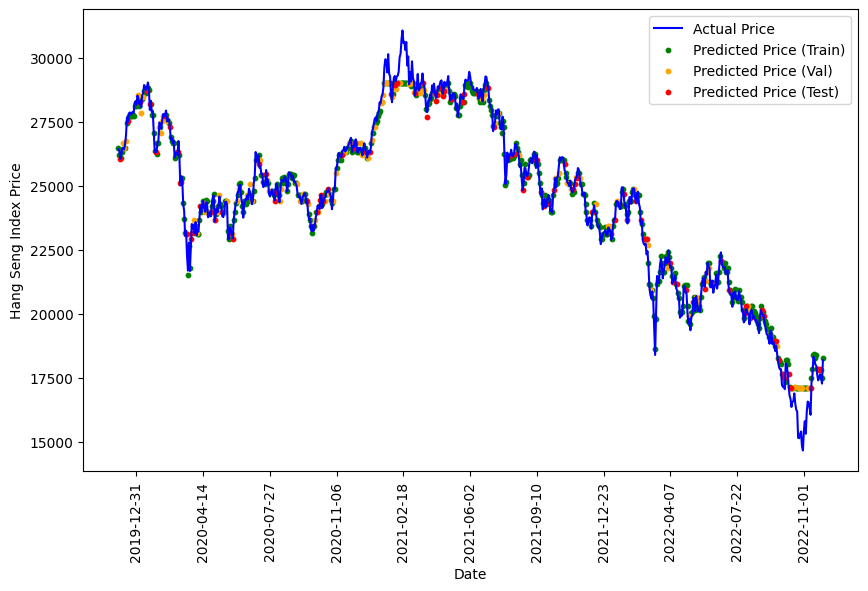

In [ ]:
X = regression_feature_df
y = full_training_data['Adj Close']
X_train, X_val, X_test, y_train, y_val, y_test, y_pred_train, y_pred_val, y_pred_test = train(X, y)
plot_graph(X_train, X_val, X_test, y_pred_train, y_pred_val, y_pred_test, 'feature')

**XGBoost Vanilla + Features + NLP Signal**

Fitting 5 folds for each of 75 candidates, totalling 375 fits
Best hyperparameters found using randomized search:
{'colsample_bytree': 0.9069251865816728, 'gamma': 0.023271935735825866, 'learning_rate': 0.04572342412944679, 'max_depth': 1, 'min_child_weight': 7, 'reg_alpha': 0.35449448286496876, 'reg_lambda': 2.090211496092452, 'subsample': 0.7773657080679304}


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[24193.34960938 20890.25976562 24480.15039062 24907.33984375
 19531.66015625 25867.00976562 28189.75       22952.24023438
 19968.38085938 25033.2109375  20765.86914062 17250.88085938
 29718.24023438 23311.0703125  29297.52929688 26156.859375
 21872.00976562 28309.75976562 23749.11914062 25878.99023438
 26192.3203125  23635.94921875 29642.27929688 21725.77929688
 26129.1796875  26389.51953125 26410.58984375 27959.59960938
 25716.         22229.51953125 20171.26953125 29476.18945312
 27655.81054688 24754.41992188 19597.31054688 28773.23046875
 22761.7109375  19689.2109375  28795.91015625 21067.99023438
 24099.140625   28496.859375   24920.75976562 25961.02929688
 26451.5390625  20661.06054688 20082.4296875  21412.40039062
 27548.51953125 21684.97070312 16832.359375   24380.
 18204.6796875  24651.58007812 19268.74023438 26498.59960938
 29248.69921875 24280.140625   23893.359375   28543.51953125
 21501.23046875 29452.5703125  24330.01953125 25263.
 16161.13964844 25481.58007812 25330.96093

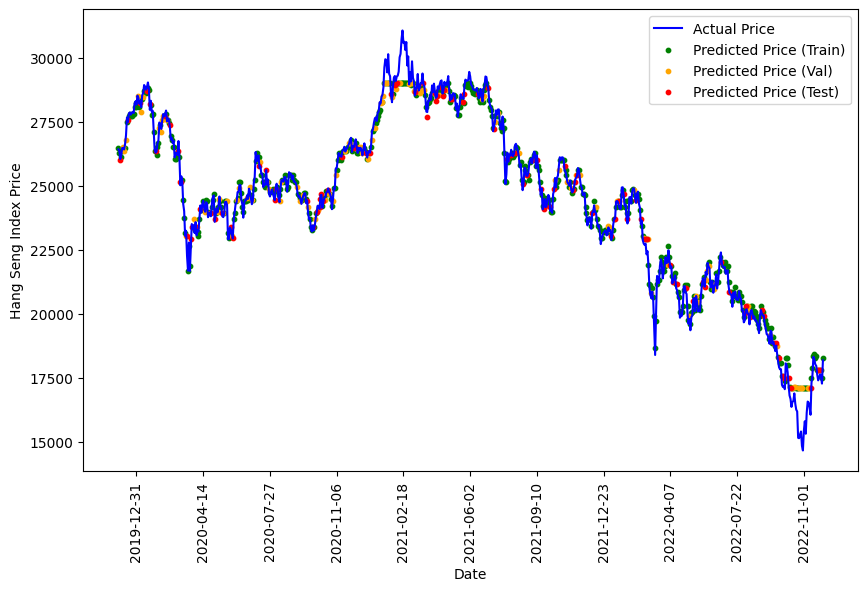

In [ ]:
X = regression_nlp_df
y = full_training_data['Adj Close']
X_train, X_val, X_test, y_train, y_val, y_test, y_pred_train, y_pred_val, y_pred_test = train(X, y)
plot_graph(X_train, X_val, X_test, y_pred_train, y_pred_val, y_pred_test, 'nlp')